In [68]:
import os
os.environ['JAX_ENABLE_X64'] = '1'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.1' 

%matplotlib widget
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import numpy as np
from temgym_core.components import Detector
from temgym_core.gaussian import GaussianRayBeta
from temgym_core.gaussian_taylor import (
    FreeSpaceParaxial, 
    Biprism,
    run_to_end,
)
from temgym_core.utils import energy2wavelength
from temgym_core.evaluate import eval_gaussians_gpu_kernel_wrapper, evaluate_gaussians_jax_scan, evaluate_gaussians_for

jax.config.update("jax_enable_x64", True)

In [69]:
W = 100e-9

Nx = Ny = 512
dx = W/Nx
dy = W/Ny
input_grid = Detector(z=0.0, pixel_size=(dx, dy), shape=(Nx, Ny))
coords = input_grid.coords
X, Y = coords[:,0].reshape(input_grid.shape), coords[:,1].reshape(input_grid.shape)
x, y = X[0,:], Y[:,0]
input_extent = (x[0], x[-1], y[0], y[-1])

distance = 1e-3
output_grid = Detector(z=distance, pixel_size=(dx * 4, dy * 4), shape=(Nx, Ny))
X_out, Y_out = output_grid.coords[:,0].reshape(output_grid.shape), output_grid.coords[:,1].reshape(output_grid.shape)
x_out, y_out = X_out[0,:], Y_out[:,0]
output_extent = (x_out[0], x_out[-1], y_out[0], y_out[-1])

voltage = 200e3
wavelength = energy2wavelength(voltage)  # 200 keV


biprism = Biprism(z=0.0, strength=-0.0003, width=20e-9, sharpness=1e11)

In [70]:
from temgym_core.gaussian import TaylorExpofAction


k0 = 2 * jnp.pi / wavelength
num_rays = 2**15

key1, key2 = jax.random.PRNGKey(0), jax.random.PRNGKey(1)
num_rays_sqrt = int(jnp.ceil(jnp.sqrt(num_rays)))

x, y = jnp.linspace(-W/2, W/2, num_rays_sqrt), jnp.linspace(-W/2, W/2, num_rays_sqrt)
x, y = jnp.meshgrid(x, y)
x, y = x.ravel(), y.ravel()
rx, ry = x[:num_rays], y[:num_rays]

w0 = 1e-9 # Beam waist
q = -1j * (2.0 / (k0 * w0**2))
Q_inv = jnp.array([[q, 0.0], [0.0, q]])
Q_inv = jnp.tile(Q_inv, (num_rays, 1, 1))

aperture_area = (W)**2
scale_factor = aperture_area / (w0 ** 2 * num_rays * np.pi)
C0 = jnp.ones(num_rays) * (1.0 * scale_factor + 0.0j)
voltage = jnp.full((num_rays,), voltage)

S = TaylorExpofAction(
    const=jnp.zeros(num_rays, dtype=jnp.complex128),
    lin=jnp.zeros((num_rays, 2), dtype=jnp.complex128),
    quad=Q_inv,
)
rays_in = GaussianRayBeta(x=rx, 
                         y=ry, 
                         dx=jnp.zeros(num_rays), 
                         dy=jnp.zeros(num_rays), 
                         z=jnp.zeros(num_rays), 
                         pathlength=jnp.zeros(num_rays),
                         _one=jnp.ones(num_rays),
                         C=C0,
                         S=S,
                         voltage=voltage)


rays_in=rays_in.to_vector()


In [71]:
E_in = evaluate_gaussians_jax_scan(rays_in, input_grid)

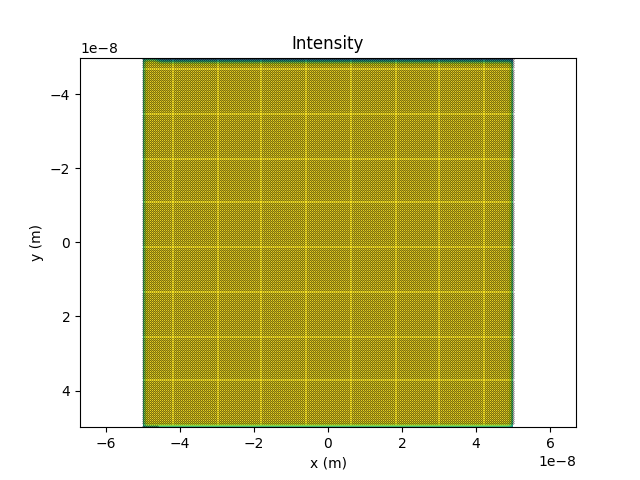

In [72]:
plt.figure()
plt.title('Intensity')
plt.axis('equal')
plt.plot(rays_in.x, rays_in.y, 'k.', markersize=0.5)
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.imshow(np.abs(E_in), extent=input_extent)


In [73]:
# Create JIT-ed single-ray and VMAP-ed batched versions without overwriting the original
run_to_end_vmapped = jax.vmap(run_to_end, in_axes=(0, None))

In [74]:
ray_out = run_to_end_vmapped(rays_in, [biprism])
E_biprism = evaluate_gaussians_jax_scan(ray_out, input_grid)

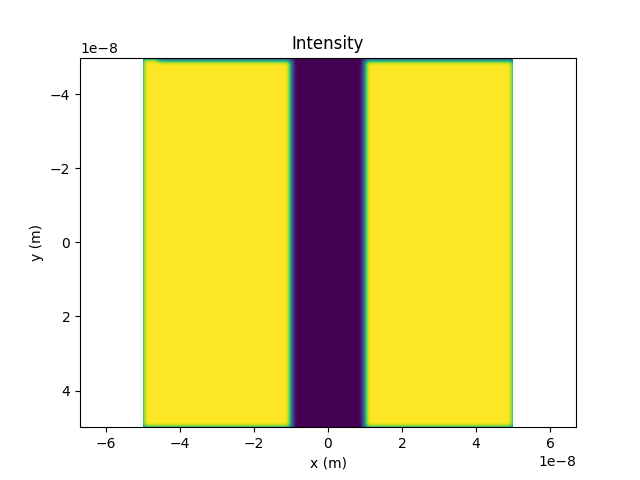

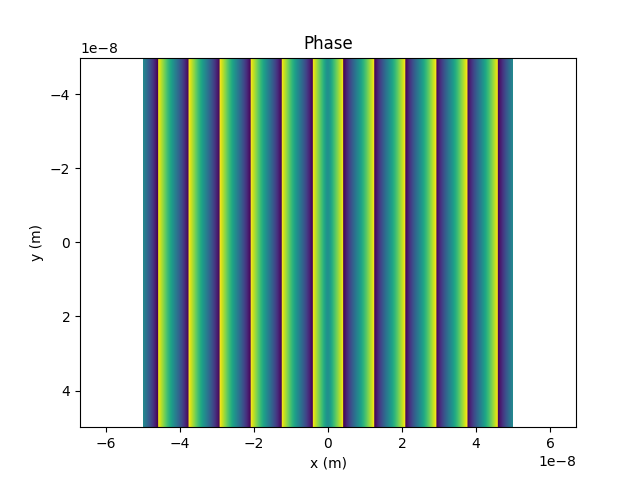

In [75]:
plt.figure()
plt.title('Intensity')
plt.axis('equal')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.imshow(np.abs(E_biprism), extent=input_extent)

plt.figure()
plt.title('Phase')
plt.axis('equal')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.imshow(np.angle(E_biprism), extent=input_extent)

In [76]:
ray_out = run_to_end_vmapped(rays_in, [biprism, output_grid])
E_out = evaluate_gaussians_jax_scan(ray_out, output_grid)

-3.4999999999999993e-07 3.4999999999999993e-07 -5e-08 4.9447513812154686e-08


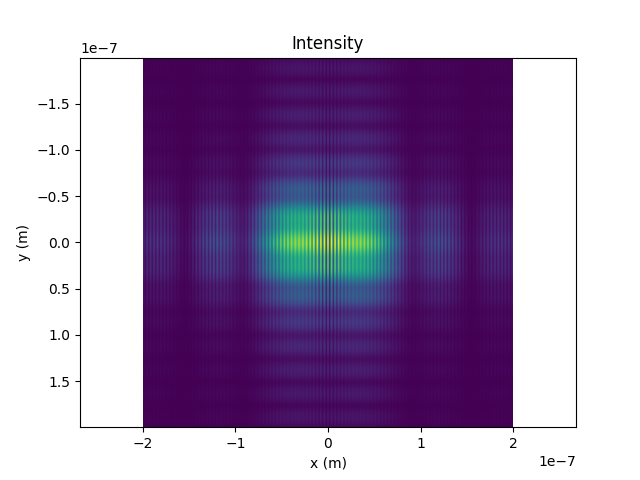

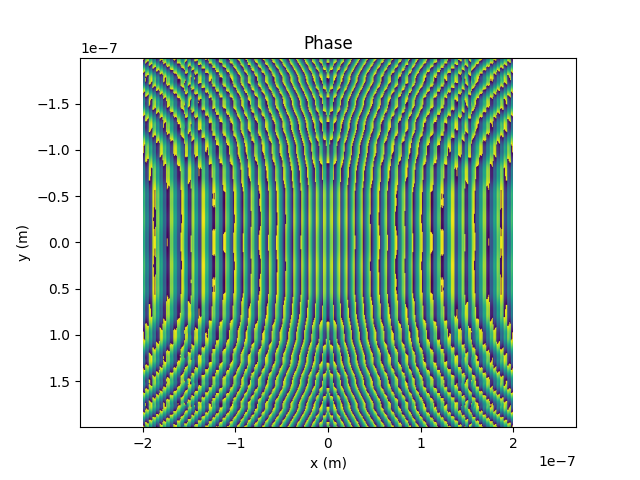

In [77]:
plt.figure()
plt.title('Intensity')
plt.axis('equal')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.plot(ray_out.x, ray_out.y, 'g.', markersize=0.5)
print(ray_out.x.min(), ray_out.x.max(), ray_out.y.min(), ray_out.y.max())
plt.imshow(np.abs(E_out), extent=output_extent)

plt.figure()
plt.title('Phase')
plt.axis('equal')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.imshow(np.angle(E_out), extent=output_extent)

In [ ]:
from temgym_core.gaussian_taylor import run_iter

num_steps = 100
biprism_iter = Biprism(z=0.0, strength=-0.000003, width=20e-9, sharpness=1e11)
free_space_iter = FreeSpaceParaxial(z=0.0, distance=distance/num_steps)

r = run_to_end(rays_in, [biprism_iter])

xs = [rays_in.x, r.x]
zs = [np.zeros_like(rays_in.x),
    np.full_like(r.x, r.z if np.isscalar(r.z) else np.array(r.z))]

for _ in range(num_steps):
    r = run_to_end(r, [free_space_iter])
    xs.append(r.x)
    zs.append(np.full_like(r.x, r.z if np.isscalar(r.z) else np.array(r.z)))

xs = np.stack(xs)
zs = np.stack(zs)

num_plot = 300
indices = np.linspace(0, xs.shape[1]-1, num_plot, dtype=int)

plt.figure()
for idx in indices:
    plt.plot(xs[:, idx], zs[:, idx], color='tab:blue', alpha=0.25, linewidth=0.4)

plt.title('Ray trajectories (subset)')
plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.gca().invert_yaxis()  # Flip vertical axis so z=0 is at the top
plt.tight_layout()
plt.show()


: 